<a href="https://colab.research.google.com/github/kabashiy/mysite/blob/master/transfer_entropy_EM_laplace_laplace_kaba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(pip|conda) install numbaが必要.  
numbaのバージョンが古くてもだめな可能性高め.  
コンパイルは結構時間かかる.  

In [ ]:
!pip install numba_scipy

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.linalg import inv 
import seaborn as sns



from numba import jit,f8,njit,prange
import numba_scipy

%matplotlib inline


In [ ]:
shc_raw = pd.read_csv("data/01_SHC-ERK_HRG_MCF/raw_SHC.csv")
shc_raw = shc_raw.set_index("time")
shc_raw = shc_raw.replace(0.0, np.nan)
shc_raw = shc_raw.fillna(shc_raw.dropna().mean(axis=0)) #これには欠損値なし
#s = np.log((shc_raw/shc_raw.iloc[0:3].mean()).drop(index=[-3,-1.5])).to_numpy()
s_tmp = (shc_raw/shc_raw.iloc[0:3].mean())
s = np.log(s_tmp).to_numpy()


erk_raw = pd.read_csv("data/01_SHC-ERK_HRG_MCF/raw_ERK.csv")
erk_raw = erk_raw.set_index("time")
erk_raw = erk_raw.replace(0.0, np.nan)
erk_raw = erk_raw.fillna(erk_raw.dropna().mean(axis=0)) 
#e = np.log((erk_raw/erk_raw.iloc[0:3].mean()).drop(index=[-3,-1.5])).to_numpy()
e_tmp = (erk_raw/erk_raw.iloc[0:3].mean())
e = np.log(e_tmp).to_numpy()

"""
shc_raw = pd.read_csv("data/02_SHC-Grb2_HRG_MCF/raw_SHC.csv")
shc_raw = shc_raw.set_index("time")
shc_raw = shc_raw.replace(0.0, np.nan)
shc_raw = shc_raw.fillna(shc_raw.dropna().mean(axis=0))
#s = np.log((shc_raw/shc_raw.iloc[0:3].mean()).drop(index=[-3,-1.5])).to_numpy()
s_tmp = (shc_raw/shc_raw.iloc[0:3].mean())
s = np.log(s_tmp).to_numpy()



grb2_raw = pd.read_csv("data/02_SHC-Grb2_HRG_MCF/raw_Grb2.csv")
grb2_raw = grb2_raw.set_index("time")
grb2_raw = grb2_raw.replace(0.0, np.nan)
grb2_raw = grb2_raw.fillna(grb2_raw.dropna().mean(axis=0))
#e = np.log((grb2_raw/grb2_raw.iloc[0:3].mean()).drop(index=[-3,-1.5])).to_numpy()
e_tmp = (grb2_raw/grb2_raw.iloc[0:3].mean())
e = np.log(e_tmp).to_numpy()
"""

"""
grb2_raw = pd.read_excel("data/03_Grb2-ERK_HRG_MCF/Grb2-ERK.xlsx",sheet_name='Grb2')
grb2_raw = grb2_raw.set_index("time")
grb2_raw = grb2_raw.replace(0.0, np.nan)
grb2_raw = grb2_raw.fillna(grb2_raw.dropna().mean(axis=0))
s = np.log((grb2_raw/grb2_raw.iloc[0:3].mean())).to_numpy()

erk_raw = pd.read_excel("data/03_Grb2-ERK_HRG_MCF/Grb2-ERK.xlsx",sheet_name='ERK')
erk_raw = erk_raw.set_index("time")
erk_raw = erk_raw.replace(0.0, np.nan)
erk_raw = erk_raw.fillna(erk_raw.dropna().mean(axis=0))
e = np.log((erk_raw/erk_raw.iloc[0:3].mean())).to_numpy()
"""



T = len(s)
M = len(s.T)

In [ ]:
mu1 = 0.4
mu2 = 0.4
sigma1 = 0.1
sigma2 = 0.2
a = 0.6
b = -0.3#-0.7#-0.3#-0.7
c = 0.6#0.8#0.6#0.8
d = 0.7
b_tmp = np.copy(b)

T = 100
M = 25

x_t = np.zeros((T,M))
y_t = np.zeros((T,M))
x = np.random.randn(M)*sigma1 + mu1
y = np.random.randn(M)*sigma2 + mu2
x_t[0] = x
y_t[0] = y
for t in range(1,T):

   
    #"""
    if t < T//2:
        pass
    else:
        b_tmp = 0.
    #"""

    x = a*x_t[t-1] + b_tmp*y_t[t-1] +mu1*np.ones(M)+sigma1*np.random.randn(M)
    x_t[t] = x 
    y = c*x_t[t-1] + d*y_t[t-1] +mu2*np.ones(M)+sigma2*np.random.randn(M)
    y_t[t] = y

        
    
s = x_t
e = y_t
T = len(x_t)



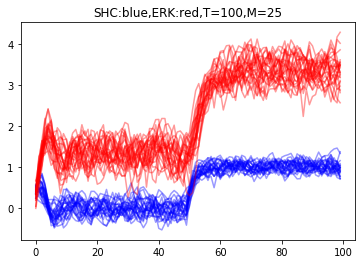

In [ ]:
## 確認用
plt.title('SHC:blue,ERK:red,T='+str(T)+',M='+str(M))
plt.plot(s,alpha=0.4,color='blue')
plt.plot(e,alpha=0.4,color='red')
plt.show()

In [ ]:

@jit('f8(f8[:],f8,f8,f8,f8)',nopython=True,cache=True)
def log_likelihood_x(theta,x_u,x_past_u,y_past_u,sigma_x):
    a_t = theta[0]
    b_t = theta[1]
    mu_t_x = theta[4]
    return -np.abs(x_u - a_t*x_past_u-b_t*y_past_u-mu_t_x)/sigma_x - np.log(sigma_x)-np.log(2)

@jit('f8(f8[:],f8,f8,f8,f8)',nopython=True,cache=True)
def log_likelihood_y(theta,y_u,x_past_u,y_past_u,sigma_y):
    c_t = theta[2]
    d_t = theta[3]
    mu_t_y = theta[5]
    return -np.abs(y_u - c_t*x_past_u-d_t*y_past_u-mu_t_y)/sigma_y - np.log(sigma_y)-np.log(2)

@jit('f8(f8[:],f8,f8,f8)',nopython=True,cache=True)
def abs_error_x(theta,x_u,x_past_u,y_past_u):
    a_t = theta[0]
    b_t = theta[1]
    mu_t_x = theta[4]
    return np.abs(x_u - a_t*x_past_u-b_t*y_past_u-mu_t_x)

@jit('f8(f8[:],f8,f8,f8)',nopython=True,cache=True)
def abs_error_y(theta,y_u,x_past_u,y_past_u):
    c_t = theta[2]
    d_t = theta[3]
    mu_t_y = theta[5]
    return np.abs(y_u - c_t*x_past_u-d_t*y_past_u-mu_t_y)




@jit('f8[:](f8[:,:],f8[:],f8[:],f8[:],f8[:],i8,i8,f8,f8)',nopython=True,cache=True,parallel=True)
def log_likelihood(theta_ens,x_t,y_t,x_t_past,y_t_past,N_ens,M,sigma_x,sigma_y):
    alpha_ens = np.zeros(N_ens)
    for i in prange(N_ens):
        theta_tmp = np.copy(theta_ens[i])
        alpha_i_tmp = 0.
        for m in prange(M):
            x_tm = 0.
            x_tm += x_t[m]
            y_tm = 0.
            y_tm += y_t[m]
            x_past_m = 0.
            x_past_m += x_t_past[m]
            y_past_m = 0.
            y_past_m += y_t_past[m]
            alpha_i_tmp += log_likelihood_x(theta_tmp,x_tm,x_past_m,y_past_m,sigma_x)+\
            log_likelihood_y(theta_tmp,y_tm,x_past_m,y_past_m,sigma_y)
        alpha_ens[i] = alpha_i_tmp 
    return alpha_ens


@jit('i8[:](f8[:])',nopython=True,parallel=True,cache=True)
def resampling(weight):
    N = weight.size
    weight_index = np.argsort(weight)
    weight_sorted = np.sort(weight)
    resampling_index = np.zeros(N)
    cumsum = np.empty(N)
    tmp = 0.
    for i in range(N):
        tmp += weight_sorted[i]
        cumsum[i] = tmp
    cumsum[-1] = 1.
    for i in prange(N):
        u = np.random.rand()
        resampling_index[i] = weight_index[(cumsum[cumsum<u]).size]
    return resampling_index.astype(np.int64)

@jit('i8[:](f8[:])',nopython=True,parallel=True,cache=True)
def residual_resampling(weight):
    ## https://arxiv.org/pdf/cs/0507025.pdf
    N = weight.size
    weight_index = np.argsort(weight)
    weight_sorted = np.sort(weight)
    resampling_index = np.zeros(N)
    weight_int = np.floor(weight_sorted*N).astype(np.int64)
    
    nonzero_counter = 0
    for i in range(N):
        for _ in range(weight_int[i]):
            resampling_index[nonzero_counter] = weight_index[i]
            nonzero_counter += 1
            
    
    weight_sorted = (N*weight_sorted-weight_int)/(N-np.sum(weight_int))

    
    cumsum = np.zeros(N)
    tmp = 0.
    for i in range(N):
        tmp += weight_sorted[i]
        cumsum[i] = tmp
    cumsum[-1] = 1.
    for i in prange(nonzero_counter,N):
        u = np.random.rand()
        resampling_index[i] = weight_index[(cumsum[cumsum<u]).size]
    return resampling_index.astype(np.int64)
    

In [ ]:
## パラメータ推定用

def PF(theta_path,alpha_path,noise_path,index_path,x,y,N_ens,r,sigma_x,sigma_y):

    deg = 1
    M = x[0].size
    T = x.T[0].size
    d2 = 4*deg+2
    neg_log_marginal_likelihood = 0.

    
    theta_ens_ = np.zeros((N_ens,d2))
    noise = np.random.laplace(size=(N_ens,d2))*r
    theta_ens_[:,-2] += x[0].mean()
    theta_ens_[:,-1] += y[0].mean()
    theta_ens = theta_ens_+noise
    
    
    theta_path[0] = theta_ens_
    noise_path[0]  = noise


    alpha_ens = np.ones(N_ens)/N_ens
    alpha_ens_ = np.ones(N_ens)/N_ens
    alpha_path[0] = np.ones(N_ens)/N_ens
    resampling_index = np.random.permutation(np.array(range(N_ens)))
    index_path[0] = resampling_index
    

    ## PF本体
    for t in range(1,T):
        
        x_t = np.copy(x)[t]
        y_t = np.copy(y)[t]
        x_t_past = np.copy(x)[t-1]
        y_t_past = np.copy(y)[t-1]
        
    
        alpha_ens = log_likelihood(theta_ens,x_t,y_t,x_t_past,y_t_past,N_ens,M,sigma_x,sigma_y)
        
        alpha_max = alpha_ens.max()
        ## logsumexpはscipy.specialなので
        const = np.log(np.sum(np.exp(alpha_ens - alpha_max)))
        alpha_ens_ = np.exp(alpha_ens  - alpha_max - const)
        alpha_path[t] = alpha_ens_

        
        alpha_max = alpha_ens.max()
        neg_log_marginal_likelihood += -np.log(np.sum(np.exp(alpha_ens - alpha_max)))-alpha_max
        
        resampling_index_prev = np.copy(resampling_index)
        resampling_index = residual_resampling(alpha_ens_)
        theta_ens_prev = np.copy(theta_ens_)
        theta_ens_ = theta_ens[resampling_index]
        
        
        index_path[t] = resampling_index

        theta_path[t] = theta_ens_
        
        noise = np.random.laplace(size=(N_ens,d2))*r
        theta_ens = theta_ens_+noise
        noise_path[t] = noise

        
    return neg_log_marginal_likelihood

In [ ]:
##サロゲートも出す
def PF_generator(x_v_path,y_v_path,theta_path,alpha_path,index_path,x,y,N_ens,r,sigma_x,sigma_y):

    deg = 1
    M = x[0].size
    T = x.T[0].size
    d2 = 4*deg+2
    
    neg_log_marginal_likelihood = 0.
    theta_ens_ = np.zeros((N_ens,d2))
    theta_ens_[:,-2] += x[0].mean()
    theta_ens_[:,-1] += y[0].mean()
    theta_ens = theta_ens_ + np.random.laplace(size=(N_ens,d2))*r
    
    theta_path[0] = theta_ens_


    alpha_ens = np.zeros(N_ens)/N_ens
    alpha_ens_ = np.zeros(N_ens)/N_ens
    resampling_index = np.random.permutation(np.array(range(N_ens)))
    index_path[0] = resampling_index
    
    ##生成する x_t,y_t
    cor = (np.linalg.cholesky(np.cov(x[0],y[0])).T).dot(np.random.randn(2,N_ens))
    x_v = x[0].mean()+cor[0]
    y_v = y[0].mean()+cor[1]
    x_v_path[0] = x_v
    y_v_path[0] = y_v

    ## PF本体
    for t in range(1,T):
        
        x_t = np.copy(x)[t]
        y_t = np.copy(y)[t]
        x_t_past = np.copy(x)[t-1]
        y_t_past = np.copy(y)[t-1]
        
        
        alpha_ens = log_likelihood(theta_ens,x_t,y_t,x_t_past,y_t_past,N_ens,M,sigma_x,sigma_y)

        
        alpha_max = alpha_ens.max()
        ## logsumexpはscipy.specialなので
        const = np.log(np.sum(np.exp(alpha_ens - alpha_max)))
        alpha_ens_ = np.exp(alpha_ens  - alpha_max - const)
        alpha_path[t] = alpha_ens_

        
        alpha_max = alpha_ens.max()
        neg_log_marginal_likelihood += -np.log(np.sum(np.exp(alpha_ens - alpha_max)))-alpha_max
        
        
        
        resampling_index_prev = np.copy(resampling_index)
        resampling_index = residual_resampling(alpha_ens_)
        theta_ens_prev = np.copy(theta_ens_)
        theta_ens_ = theta_ens[resampling_index]
        
        
        index_path[t] = resampling_index
        
        x_v_p = x_v[resampling_index_prev]
        y_v_p = y_v[resampling_index_prev]
        for i in range(N_ens):
            x_v[i]  = theta_ens_prev[i,0]*x_v_p[i]+theta_ens_prev[i,1]*y_v_p[i]+theta_ens_prev[i,4]+np.random.laplace()*sigma_x 
            y_v[i]  = theta_ens_prev[i,2]*x_v_p[i]+theta_ens_prev[i,3]*y_v_p[i]+theta_ens_prev[i,5]+np.random.laplace()*sigma_y
        theta_ens = theta_ens_+np.random.laplace(size=(N_ens,d2))*r
        
        
    

        x_v_path[t] = x_v
        y_v_path[t] = y_v
        theta_path[t] = theta_ens_
        
        
    return neg_log_marginal_likelihood
        

In [ ]:
@jit('f8[:](f8[:,:,:],f8[:,:],f8[:,:,:],f8[:,:],f8[:,:],f8)',nopython=True,cache=True,parallel=True)
def calc_param(theta_path,alpha_path,noise_path,x,y,r):
    T = alpha_path.T[0].size
    N_ens = alpha_path[0].size
    M = x[0].size
    d2 = 6
    sig_x = 0.
    sig_y = 0.
    r_new = 0.
    weight = np.ones(N_ens)/N_ens
    for t in range(1,T):
        alpha = alpha_path[t]
        theta_N = theta_path[t]
        theta_N_past = theta_path[t-1]
        noise_N = noise_path[t-1]
        x_abs_N = np.zeros(N_ens)
        y_abs_N = np.zeros(N_ens)
        r_N = np.zeros(N_ens)
        x_t = np.copy(x[t])
        y_t = np.copy(y[t])
        x_past = np.copy(x[t-1])
        y_past = np.copy(y[t-1])
        for i in prange(N_ens):
            theta = np.zeros(d2)
            theta_past = np.zeros(d2)
            theta += theta_N[i]
            theta_past += theta_N_past[i]
            noise = np.zeros(d2)
            noise += noise_N[i]
            for m in prange(M):
                x_tm = 0.
                x_tm += x_t[m]
                y_tm = 0.
                y_tm += y_t[m]
                x_past_m = 0.
                x_past_m += x_past[m]
                y_past_m = 0.
                y_past_m += y_past[m]
                x_abs_N[i] += abs_error_x(theta,x_tm,x_past_m,y_past_m)
                y_abs_N[i] += abs_error_y(theta,y_tm,x_past_m,y_past_m)
            for d  in prange(d2):
                theta_d = 0.
                theta_d += theta[d]
                theta_past_d = 0.
                theta_past_d += theta_past[d]
                r_N[i] += np.abs(theta_d-theta_past_d)
                #noise_d = 0.
                #noise_d += noise[d]
                #r_N[i] += np.abs(noise_d)
                
            sig_x += x_abs_N[i]/N_ens
            sig_y += y_abs_N[i]/N_ens
            r_new += r_N[i]/N_ens#*alpha[i]#
    return np.array([sig_x/(M*(T)),sig_y/(M*(T)),r_new/((T)*d2)])
    #return np.array([sig_x/(M*T),sig_y/(M*T),np.sqrt(1/(r_new_inv/(T*d2)))])

In [ ]:
N_ens = 1500 ##粒子数
N_iter = 100 ##繰り返し数
d2 = 6

sigma_x = 0.3
sigma_y = 0.3

#r = 0.009
r = 0.03

NLML_iter = np.zeros(N_iter)
sigma_x_path = np.zeros(N_iter)
sigma_y_path = np.zeros(N_iter)
r_path = np.zeros(N_iter)
for i in range(N_iter):
    theta_path = np.zeros((T,N_ens,d2))
    noise_path = np.zeros((T,N_ens,d2))
    alpha_path = np.zeros((T,N_ens))
    index_path = np.zeros((T,N_ens),dtype=int)
    NLML = PF(theta_path,alpha_path,noise_path,index_path,s,e,N_ens,r,sigma_x,sigma_y)

    sigma_x,sigma_y,r = calc_param(theta_path,alpha_path,noise_path,s,e,r)
    #sigma_x,sigma_y,r = calc_param2(theta_path,alpha_path,index_path,s,e,r)
    sigma_x_path[i] = sigma_x
    sigma_y_path[i] = sigma_y
    r_path[i] = r
    NLML_iter[i] = NLML

In [ ]:
theta_path = np.zeros((T,N_ens,d2))
noise_path = np.zeros((T,N_ens,d2))
alpha_path = np.zeros((T,N_ens))
NLML = 0.
NLML = PF(theta_path,alpha_path,noise_path,index_path,s,e,N_ens,r,sigma_x,sigma_y)
theta_path.mean(axis=1).mean(axis=0)

array([ 0.56873738, -0.13337782,  0.53760068,  0.70695401,  0.40039404,
        0.45204548])

In [ ]:
NLML

-2552.251517277102

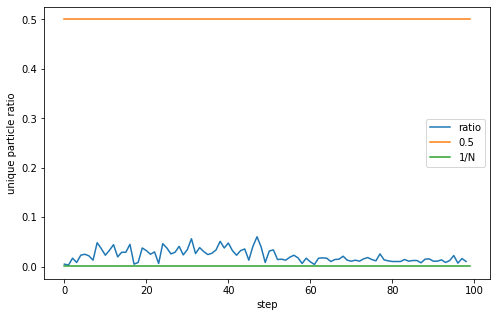

In [ ]:
num2 = np.array([len(np.unique(theta_path[t])) for t in range(1,T)])
plt.figure(figsize=(8,5))
#plt.semilogy(num_perm/(N_ens*d2),label='perm')
plt.plot(num2/(N_ens*d2),label='ratio')
plt.plot(np.ones(T)*0.5,label='0.5')
plt.plot(np.ones(T)/N_ens,label='1/N')
plt.ylabel("unique particle ratio")
plt.xlabel("step")
plt.legend()

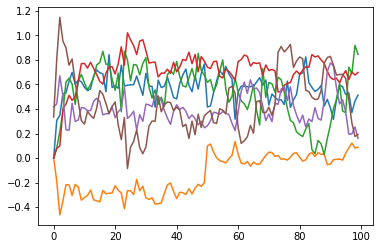

In [ ]:
plt.plot(theta_path.mean(axis=1))
plt.show()

In [ ]:
(a,b,c,d,mu1,mu2)

(0.6, -0.3, 0.6, 0.7, 0.4, 0.4)

In [ ]:
theta_path.mean(axis=1).mean(axis=0)

array([ 0.56873738, -0.13337782,  0.53760068,  0.70695401,  0.40039404,
        0.45204548])

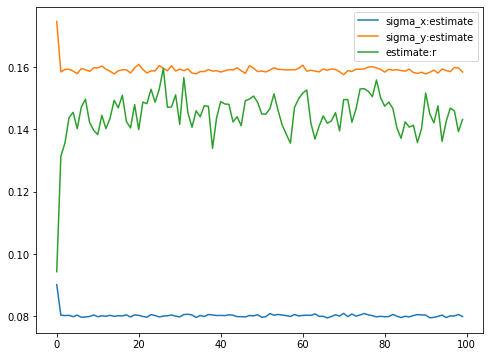

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(sigma_x_path,label="sigma_x:estimate")
#plt.plot(sigma1*np.ones(N_iter),label="sigma_x:true")
plt.plot(sigma_y_path,label="sigma_y:estimate")
#plt.plot(sigma2*np.ones(N_iter),label="sigma_y:true")
plt.plot(r_path,label="estimate:r")
#plt.plot(r_true*np.ones(N_iter),label="r:true")
plt.legend()
plt.show()

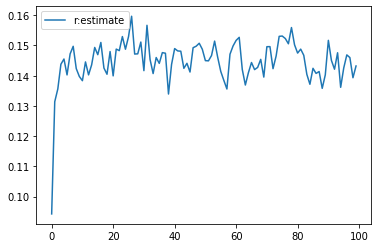

0.1432066967692718


In [ ]:
plt.plot(r_path,label="r:estimate")
plt.legend()
plt.show()
print(r)

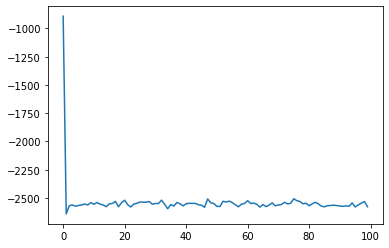

-2552.251517277102


In [ ]:
plt.plot(NLML_iter)
plt.show()
print(NLML)

In [ ]:
(r,sigma_x,sigma_y)

(0.1432066967692718, 0.07989252780800107, 0.15844732135039036)

In [ ]:
theta_path = np.zeros((T,N_ens,d2))
noise_path = np.zeros((T,N_ens,d2))
x_v_path = np.zeros((T,N_ens))
y_v_path = np.zeros((T,N_ens))
alpha_path = np.zeros((T,N_ens))
index_path = np.zeros((T,N_ens),dtype = int)
NLML = PF_generator(x_v_path,y_v_path,theta_path,alpha_path,index_path,s,e,N_ens,r,sigma_x,sigma_y)

In [ ]:
NLML

-2559.7809497490452

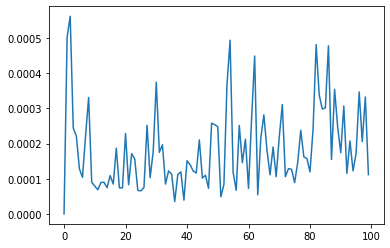

In [ ]:
##重みの時刻ごとの分散
plt.plot(range(T),alpha_path.var(axis=1))

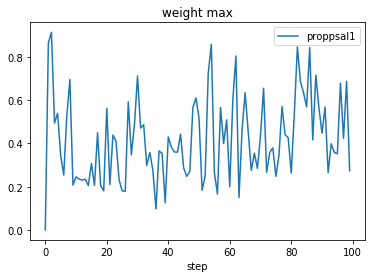

In [ ]:
plt.title("weight max")
plt.plot(alpha_path.max(axis=1),label="proppsal1")
plt.xlabel("step")
plt.legend()

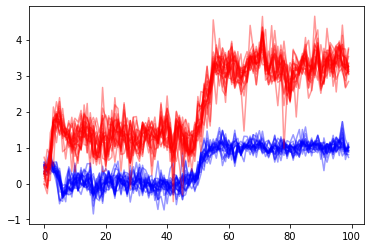

In [ ]:
##生成されたパスを少しだけみる
plt.plot(x_v_path[:,:20],color="blue",alpha=0.4)
plt.plot(y_v_path[:,:20],color="red",alpha=0.4)
plt.show()

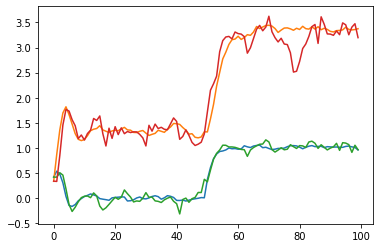

In [ ]:
#元のパスの平均と生成されたパスの平均の比較

plt.plot(s.mean(axis=1))
plt.plot(e.mean(axis=1))

plt.plot(x_v_path.mean(axis=1))
plt.plot(y_v_path.mean(axis=1))


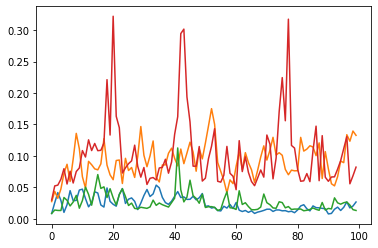

In [ ]:
plt.plot(s.var(axis=1))
plt.plot(e.var(axis=1))
plt.plot(x_v_path.var(axis=1))
plt.plot(y_v_path.var(axis=1))

In [ ]:
@jit('f8[:,:](f8[:,:],f8[:,:],f8[:,:,:],f8,f8,)',nopython=True,cache=True,parallel=True)
def calc_te_mc(x_v_path,y_v_path,theta_path,sigma_x,sigma_y):
    T = x_v_path.T[0].size
    N_ens = theta_path[0,:,0].size
    te = np.zeros((2,T))
    for t in range(1,T):
        y_t_past = y_v_path[t-1]
        x_t_past = x_v_path[t-1]
        theta_t = theta_path[t]
        y_t = y_v_path[t]
        x_t = x_v_path[t]
    
        xtoy1 = np.zeros((N_ens,N_ens))
        xtoy2 = np.zeros((N_ens,N_ens))
        ytox1 = np.zeros((N_ens,N_ens))
        ytox2 = np.zeros((N_ens,N_ens))
        
        
        for k in prange(N_ens):
            for i in prange(N_ens):
                xtoy2[k,i] += np.exp(log_likelihood_y(theta_t[i],y_t[k],x_t_past[k],y_t_past[k],sigma_y))
                xtoy1[k,i] += np.exp(log_likelihood_y(theta_t[i],y_t[k],x_t_past[i],y_t_past[k],sigma_y))
                ytox2[k,i] += np.exp(log_likelihood_x(theta_t[i],x_t[k],x_t_past[k],y_t_past[k],sigma_x))
                ytox1[k,i] += np.exp(log_likelihood_x(theta_t[i],x_t[k],x_t_past[k],y_t_past[i],sigma_x))

        pyxy = xtoy2.sum(axis=1)
        pyy = xtoy1.sum(axis=1)
        pyxy_n = pyxy/pyxy.sum()
        pyy_n = pyy/pyy.sum()
        te_xtoy_t = pyxy_n@np.log(pyxy_n/pyy_n)
        
        
        
        pxxy = ytox2.sum(axis=1)
        pxx = ytox1.sum(axis=1)
        pxxy_n = pxxy/pxxy.sum()
        pxx_n = pxx/pxx.sum()    
        te_ytox_t = pxxy_n@np.log(pxxy_n/pxx_n)

        te[0,t] = te_ytox_t
        te[1,t] = te_xtoy_t
    return te

In [ ]:

te_mc = calc_te_mc(x_v_path,y_v_path,theta_path,sigma_x,sigma_y)

te_ytox_mc = te_mc[0]
te_xtoy_mc = te_mc[1]

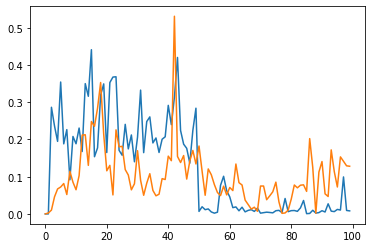

In [ ]:
plt.plot(te_ytox_mc)
plt.plot(te_xtoy_mc)

#plt.plot(te_ytox,label='TE:y→x')
#plt.plot(te_xtoy,label='TE:x→y')
plt.show()

In [ ]:
N_iter = 10


d2 = 4*1+2

N_ens = 1500



NLML_N = np.zeros(N_iter)
NLML_N_perm = np.zeros(N_iter)
te_ytox_N = np.zeros((N_iter,T))
te_xtoy_N = np.zeros((N_iter,T))
te_ytox_perm_N = np.zeros((N_iter,T))
te_xtoy_perm_N = np.zeros((N_iter,T))


for i in range(N_iter):
    theta_path = np.zeros((T,N_ens,d2))
    x_v_path = np.zeros((T,N_ens))
    y_v_path = np.zeros((T,N_ens))
    alpha_path = np.zeros((T,N_ens))
    index_path = np.zeros((T,N_ens),dtype = int)
    NLML = 0.
    NLML = PF_generator(x_v_path,y_v_path,theta_path,alpha_path,index_path,s,e,N_ens,r,sigma_x,sigma_y)
    NLML_N[i] = NLML
    
    
    te_mc = calc_te_mc(x_v_path,y_v_path,theta_path,sigma_x,sigma_y)

    te_ytox_mc = te_mc[0]
    te_xtoy_mc = te_mc[1]
    te_ytox_N[i] = te_ytox_mc
    te_xtoy_N[i] = te_xtoy_mc
    
    
    soeji=list(range(M))
    np.random.shuffle(soeji)
    e_perm = e[:,soeji].copy()
    theta_path = np.zeros((T,N_ens,d2))
    x_v_path = np.zeros((T,N_ens))
    y_v_path = np.zeros((T,N_ens))
    alpha_path = np.zeros((T,N_ens))
    NLML_perm = 0.   
    NLML_perm = PF_generator(x_v_path,y_v_path,theta_path,alpha_path,index_path,s,e_perm,N_ens,r,sigma_x,sigma_y)
    
    NLML_N_perm[i] = NLML_perm
    
    te_mc = calc_te_mc(x_v_path,y_v_path,theta_path,sigma_x,sigma_y)
    te_ytox_mc = te_mc[0]
    te_xtoy_mc = te_mc[1]
    
    te_ytox_perm_N[i] = te_ytox_mc
    te_xtoy_perm_N[i] = te_xtoy_mc
    
    if (i+1)%10 == 0:
        print(str((i+1)/N_iter*100)+'%')

100.0%


In [ ]:
df_te_xtoy_N = pd.DataFrame(te_xtoy_N)
df_te_ytox_N = pd.DataFrame(te_ytox_N)
df_te_xtoy_perm_N = pd.DataFrame(te_xtoy_perm_N)
df_te_ytox_perm_N = pd.DataFrame(te_ytox_perm_N)


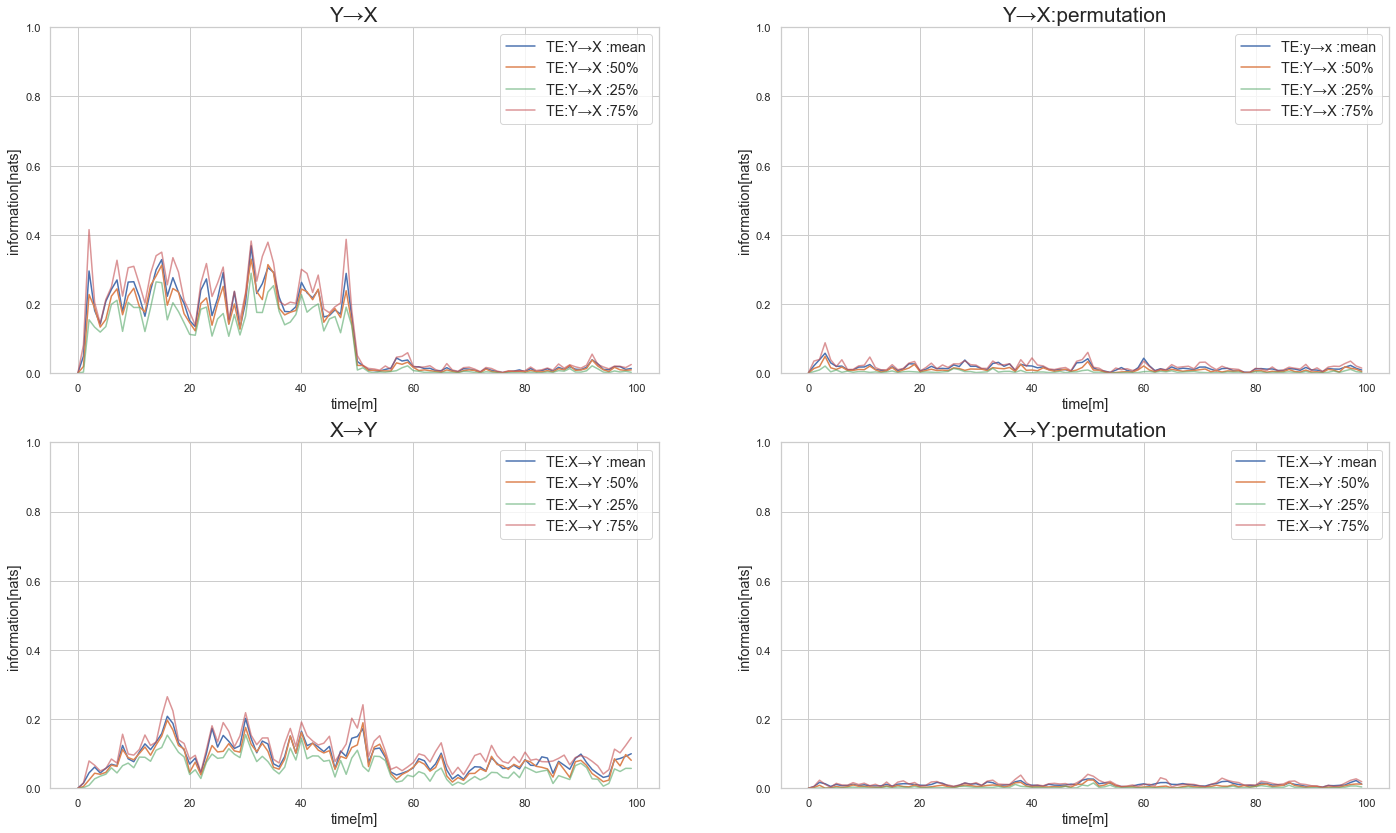

In [ ]:

time = range(T)#np.array(range(-2,T-2,1))*1.5

ylim = 1

sns.set()
sns.set_style('whitegrid')
fig, ax = plt.subplots(2,2, figsize = (24,14))
ax[0,0].set_title('Y→X',fontsize="xx-large")
ax[0,0].plot(time,df_te_ytox_N.mean(),label='TE:Y→X :mean')
#ax[0,0].plot(time,te_ytox,label='TE:Y→X :true')
ax[0,0].plot(time,df_te_ytox_N.quantile(0.5),label='TE:Y→X :50%')
ax[0,0].plot(time,df_te_ytox_N.quantile(0.25),label='TE:Y→X :25%',alpha=0.6)
ax[0,0].plot(time,df_te_ytox_N.quantile(0.75),label='TE:Y→X :75%',alpha=0.6)

ax[0,0].set_ylim(0,ylim)
ax[0,0].set_ylabel('information[nats]',fontsize="large")
ax[0,0].set_xlabel('time[m]',fontsize="large")
ax[0,0].legend(fontsize="large")


ax[1,0].set_title('X→Y',fontsize="xx-large")
ax[1,0].plot(time,df_te_xtoy_N.mean(),label='TE:X→Y :mean')
#ax[1,0].plot(time,te_xtoy,label='TE:X→Y :true')
ax[1,0].plot(time,df_te_xtoy_N.quantile(0.5),label='TE:X→Y :50%')
ax[1,0].plot(time,df_te_xtoy_N.quantile(0.25),label='TE:X→Y :25%',alpha=0.6)
ax[1,0].plot(time,df_te_xtoy_N.quantile(0.75),label='TE:X→Y :75%',alpha=0.6)

ax[1,0].set_ylim(0,ylim)
ax[1,0].set_ylabel('information[nats]',fontsize="large")
ax[1,0].set_xlabel('time[m]',fontsize="large")
ax[1,0].legend(fontsize="large")


ax[0,1].set_title('Y→X:permutation',fontsize="xx-large")
ax[0,1].plot(time,df_te_ytox_perm_N.mean(),label='TE:y→x :mean')
ax[0,1].plot(time,df_te_ytox_perm_N.quantile(0.5),label='TE:Y→X :50%')
ax[0,1].plot(time,df_te_ytox_perm_N.quantile(0.25),label='TE:Y→X :25%',alpha=0.6)
ax[0,1].plot(time,df_te_ytox_perm_N.quantile(0.75),label='TE:Y→X :75%',alpha=0.6)
ax[0,1].set_ylim(0,ylim)
ax[0,1].set_ylabel('information[nats]',fontsize="large")
ax[0,1].set_xlabel('time[m]',fontsize="large")
ax[0,1].legend(fontsize="large")

ax[1,1].set_title('X→Y:permutation',fontsize="xx-large")
ax[1,1].plot(time,df_te_xtoy_perm_N.mean(),label='TE:X→Y :mean')
ax[1,1].plot(time,df_te_xtoy_perm_N.quantile(0.5),label='TE:X→Y :50%')
ax[1,1].plot(time,df_te_xtoy_perm_N.quantile(0.25),label='TE:X→Y :25%',alpha=0.6)
ax[1,1].plot(time,df_te_xtoy_perm_N.quantile(0.75),label='TE:X→Y :75%',alpha=0.6)
ax[1,1].set_ylim(0,ylim)
ax[1,1].set_ylabel('information[nats]',fontsize="large")
ax[1,1].set_xlabel('time[m]',fontsize="large")
ax[1,1].legend(fontsize="large")
plt.show()

(-1718.2282955888277, 16.855529118530516)

以下bootstrap検定  
いまだに関数にしてないので頭から順々に実行したら結果がでる

In [ ]:
te_ytox = df_te_ytox_N.to_numpy()
te_xtoy = df_te_xtoy_N.to_numpy()
te_ytox_perm = df_te_ytox_perm_N.to_numpy()
te_xtoy_perm = df_te_xtoy_perm_N.to_numpy()

T = len(te_ytox.T)
B = 2000#N_iter
p_mean = np.zeros(T)
p_med = np.zeros(T)

for t in range(T):
    
    te_merge = np.r_[te_ytox[:,t],te_ytox_perm[:,t]]
    
    mean = np.mean(te_ytox[:,t])#-np.mean(te_ytox_perm[:,t])
    med = np.median(te_ytox[:,t])#-np.median(te_ytox_perm[:,t])
    
    mean_B = 0.
    med_B = 0.
    for b in range(B):
        ytox_B = np.random.choice(te_merge,N_iter)
        ytox_perm_B = np.random.choice(te_merge,N_iter)

        mean_b = np.mean(ytox_B)#-np.mean(ytox_perm_B)
        med_b = np.median(ytox_B)#-np.median(ytox_perm_B)

        if mean_b >= mean:
            mean_B += 1 
        if med_b >= med:
            med_B += 1

    mean_B = mean_B/B
    med_B = med_B/B
        
    p_mean[t] = mean_B
    p_med[t] = med_B

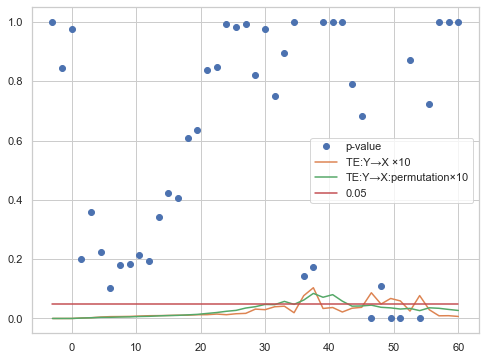

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(time,p_mean,'o',label='p-value')
#plt.plot(time,np.mean(te_xtoy,axis=0)-np.mean(te_ytox_perm,axis=0),label='TE:Y→X :diff mean')
plt.plot(time,np.mean(te_ytox,axis=0)*10,label='TE:Y→X ×10')
plt.plot(time,np.mean(te_ytox_perm,axis=0)*10,label='TE:Y→X:permutation×10')
plt.plot(time,time*0+0.05,label=0.05)
plt.legend()

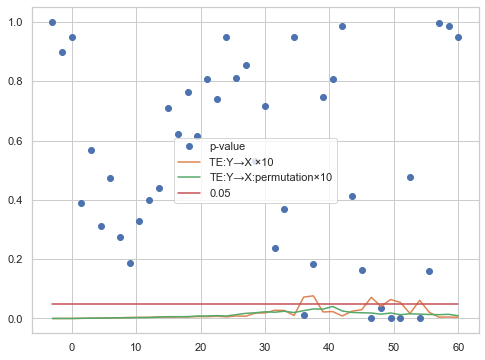

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(time,p_med,'o',label='p-value')
#plt.plot(time,np.mean(te_xtoy,axis=0)-np.mean(te_ytox_perm,axis=0),label='TE:Y→X :diff mean')
plt.plot(time,np.median(te_ytox,axis=0)*10,label='TE:Y→X ×10')
plt.plot(time,np.median(te_ytox_perm,axis=0)*10,label='TE:Y→X:permutation×10')
plt.plot(time,time*0+0.05,label='0.05')
plt.legend()

In [ ]:
T = len(te_xtoy.T)
B = 2000
p_mean = np.zeros(T)
p_med = np.zeros(T)

for t in range(T):
    
    te_merge = np.r_[te_xtoy[:,t],te_xtoy_perm[:,t]]
    
    mean = np.mean(te_xtoy[:,t])#-np.mean(te_ytox_perm[:,t])
    med = np.median(te_xtoy[:,t])#-np.median(te_ytox_perm[:,t])
    
    mean_B = 0.
    med_B = 0.
    for b in range(B):
        xtoy_B = np.random.choice(te_merge,N_iter)
        xtoy_perm_B = np.random.choice(te_merge,N_iter)

        mean_b = np.mean(xtoy_B)#-np.mean(ytox_perm_B)
        med_b = np.median(xtoy_B)#-np.median(ytox_perm_B)

        if mean_b >= mean:
            mean_B += 1 
        if med_b >= med:
            med_B += 1

    mean_B = mean_B/B
    med_B = med_B/B
        
    p_mean[t] = mean_B
    p_med[t] = med_B

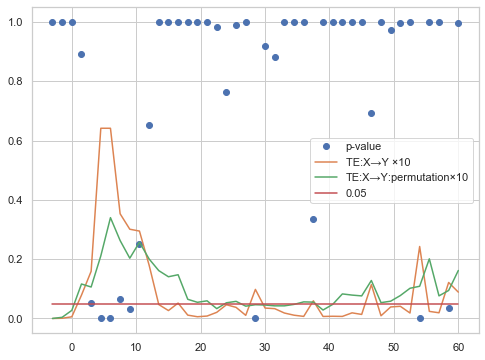

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(time,p_mean,'o',label='p-value')
#plt.plot(time,np.mean(te_xtoy,axis=0)-np.mean(te_ytox_perm,axis=0),label='TE:Y→X :diff mean')
plt.plot(time,np.mean(te_xtoy,axis=0)*10,label='TE:X→Y ×10')
plt.plot(time,np.mean(te_xtoy_perm,axis=0)*10,label='TE:X→Y:permutation×10')
plt.plot(time,time*0+0.05,label=0.05)
plt.legend()

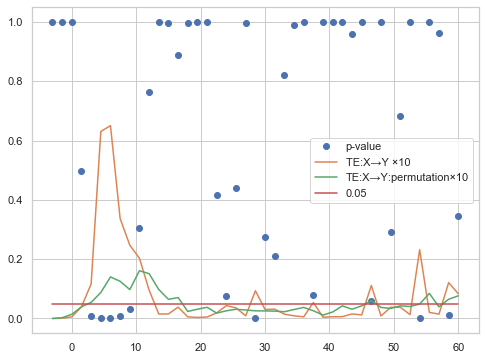

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(time,p_med,'o',label='p-value')
#plt.plot(time,np.mean(te_xtoy,axis=0)-np.mean(te_ytox_perm,axis=0),label='TE:Y→X :diff mean')
plt.plot(time,np.median(te_xtoy,axis=0)*10,label='TE:X→Y ×10')
plt.plot(time,np.median(te_xtoy_perm,axis=0)*10,label='TE:X→Y:permutation×10')
plt.plot(time,time*0+0.05,label=0.05)
plt.legend()

In [ ]:
##VAR1のTEの理論値 

mu1 = 0.4
mu2 = 0.4
sigma1 = 0.1
sigma2 = 0.2
a = 0.6
b = -0.3
c = 0.6
d = 0.7


A = np.zeros((2,2))
A[0,0] = a
A[0,1] = b
A[1,0] = c
A[1,1] = d

ν = np.zeros(2)
ν[0] = mu1
ν[1] = mu2
ν_t = np.copy(ν)
Σ_t = np.eye(2)
Σ_t[0,0] = sigma1**2
Σ_t[1,1] = sigma2**2
Σ = np.copy(Σ_t)
ν_path = np.zeros((T,2))
Σ_path = np.zeros((T,2,2))
ν_path[0] = ν_t
Σ_path[0] = Σ_t
for t in range(T):

    if t >= T/2-1:
        A[0,1] = 0.

    Σ_new = Σ + A@Σ_t@A.T #
    ν_t = ν + Σ_new@inv(Σ)@A@inv(inv(Σ_t)+A.T@inv(Σ)@A)@inv(Σ_t)@ν_t
    Σ_t = Σ_new
    ν_path[t] = ν_t
    Σ_path[t] = Σ_t

K = np.zeros((3,3))
K[0,0] = 1
K[0,1] = -a
K[0,2] = -b
K[1,0] = -a
K[1,1] = a**2
K[1,2] = a*b
K[2,0] = -b
K[2,1] = a*b
K[2,2] = b**2

K2 = np.zeros((3,3))
K2[0,0] = 1
K2[0,1] = -a
K2[1,0] = -a
K2[1,1] = a**2

L = np.zeros((3,3))
L[0,0] = 1
L[0,1] = -c
L[0,2] = -d
L[1,0] = -c
L[1,1] = c**2
L[1,2] = c*d
L[2,0] = -d
L[2,1] = c*d
L[2,2] = d**2

L2 = np.zeros((3,3))
L2[0,0] = 1
L2[0,2] = -d
L2[2,0] = -d
L2[2,2] = d**2

## Σ_xはx_t+1,x_t,y_t, Σ_yはy_t+1,x_t,y_tの同時分布 μも同様
Σ_expand = np.zeros((3,3))
Σ_x_path = np.zeros((T,3,3))
Σ_y_path = np.zeros((T,3,3))
μ_x_path = np.zeros((T,3))
μ_y_path = np.zeros((T,3))
for t in range(1,T):
    Σ_tmp = np.zeros((3,3))
    Σ_tmp[1:,1:] = inv(Σ_path[t])
    

    
    Σ_x = inv(1/sigma1**2*K + Σ_tmp)
    Σ_y = inv(1/sigma2**2*L + Σ_tmp)
    Σ_x_path[t] = Σ_x
    Σ_y_path[t] = Σ_y
    
    mu_x1 = np.zeros(3)
    mu_x1[0] = ν[0]
    mu_y1 = np.zeros(3)
    mu_y1[0] = ν[1]
    
    mu_x2 = np.zeros(3)
    mu_x2[1:] = ν_path[t]
    mu_y2 = np.zeros(3)
    mu_y2[1:] = ν_path[t]
    
    μ_x = Σ_x@(K@mu_x1/sigma1**2+Σ_tmp@mu_x2)
    μ_y = Σ_y@(L@mu_y1/sigma2**2+Σ_tmp@mu_y2)
    μ_x_path[t] = μ_x
    μ_y_path[t] = μ_y

K = np.zeros((3,3))
K[0,0] = 1
K[0,1] = -a
K[0,2] = -b
K[1,0] = -a
K[1,1] = a**2
K[1,2] = a*b
K[2,0] = -b
K[2,1] = a*b
K[2,2] = b**2

te_ytox = np.zeros(T)
te_xtoy = np.zeros(T)
for t in range(1,T):
    
    if t >= T/2-1:    
        K[0,2] = 0#-b
        K[1,2] = 0#a*b
        K[2,0] = 0#-b
        K[2,1] = 0#a*b
        K[2,2] = 0#b**2
        b = 0
   
    
    te_ytox_t = 0.
    #""" いらないんじゃね？
    te_ytox_t += -0.5/sigma1**2*np.trace(K@(Σ_x_path[t]+np.outer(μ_x_path[t],μ_x_path[t])))
    ν_x_expand = np.zeros(3)
    ν_x_expand[0] = ν[0]
    te_ytox_t += 1/sigma1**2*ν_x_expand.T@K@μ_x_path[t]
    te_ytox_t += -0.5/sigma1**2*ν[0]**2
    
    te_ytox_t += 0.5/(b**2*Σ_path[t,1,1]+sigma1**2)*np.trace(K2@(Σ_x_path[t]+np.outer(μ_x_path[t],μ_x_path[t])))
    ν_x_expand2 = np.zeros(3)
    ν_x_expand2[0] = ν[0]+b*ν_path[t,1]
    te_ytox_t += -1/(b**2*Σ_path[t,1,1]+sigma1**2)*ν_x_expand2.T@K2@μ_x_path[t]
    te_ytox_t += 0.5/(b**2*Σ_path[t,1,1]+sigma1**2)*(ν[0]+b*ν_path[t,1])**2
    #"""
    te_ytox_t += 0.5*np.log(1+b**2*Σ_path[t,1,1]/sigma1**2)

    te_ytox[t] = te_ytox_t
    
    te_xtoy_t = 0.
    #"""いらないんじゃね
    te_xtoy_t += -0.5/sigma2**2*np.trace(L@(Σ_y_path[t]+np.outer(μ_y_path[t],μ_y_path[t])))
    ν_y_expand = np.zeros(3)
    ν_y_expand[0] = ν[1]
    te_xtoy_t += 1/sigma2**2*ν_y_expand.T@L@μ_y_path[t]
    te_xtoy_t += -0.5/sigma2**2*ν[1]**2
    
    te_xtoy_t += 0.5/(c**2*Σ_path[t,0,0]+sigma2**2)*np.trace(L2@(Σ_y_path[t]+np.outer(μ_y_path[t],μ_y_path[t])))
    ν_y_expand2 = np.zeros(3)
    ν_y_expand2[0] = ν[1]+c*ν_path[t,0]
    te_xtoy_t += -1/(c**2*Σ_path[t,0,0]+sigma2**2)*ν_y_expand2.T@L2@μ_y_path[t]
    te_xtoy_t += 0.5/(c**2*Σ_path[t,0,0]+sigma2**2)*(ν[1]+c*ν_path[t,0])**2
    #"""
    
    te_xtoy_t += 0.5*np.log(1+c**2*Σ_path[t,0,0]/sigma2**2)
    
    te_xtoy[t] = te_xtoy_t
    

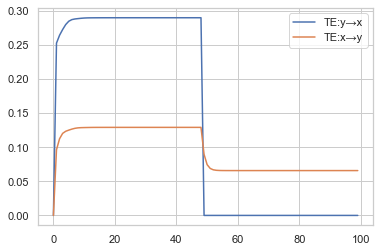

In [ ]:
plt.plot(te_ytox,label='TE:y→x')
plt.plot(te_xtoy,label='TE:x→y')
plt.legend()